In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
#sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")
sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")

In [ ]:
import numpy as np
import pandas as
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sys
from glob import iglob

In [ ]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.25.2 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


In [ ]:
# the directory with the `.h5` file
# use gene symbols for the variable names (variables-axis index)
output_dir="/content/drive/MyDrive/LeoDai/Private_Data/Preprocessing/rat"
output_fig_dir="/content/drive/MyDrive/LeoDai/Private_Data/Preprocessing/rat/Figs"
input_dir="/content/drive/MyDrive/LeoDai/Private_Data/rat"
gene_screenfile="/content/drive/MyDrive/LeoDai/Private_Data/Preprocessing/rat/Rat_chrXYMT_gene.txt"
outfile="/content/drive/MyDrive/LeoDai/Private_Data/Preprocessing/rat/rat_all_norm_pca_cluster.h5ad"
sc.settings.figdir = output_dir
mt_genefile="/content/drive/MyDrive/LeoDai/Private_Data/Preprocessing/rat/rat_mt_genes.txt"

mt_genelist = pd.read_csv(mt_genefile,index_col=False,sep="\t",header=0)


In [ ]:
adatalist = []
dirlist = os.listdir(input_dir)
rm_genelist = pd.read_csv(gene_screenfile,index_col=False,sep="\t",header=0)
rm_genelist.head()

In [ ]:
results_file=os.path.join(output_dir,outfile)
for smp_name in dirlist:
    print(smp_name)
    adata = sc.read_10x_h5(os.path.join(input_dir,smp_name,"filtered_feature_bc_matrix.h5"))

    #print((np.unique(adata.var_names)).shape)
    # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
    adata.var_names_make_unique()

    adata.obs_names = [f"{smp_name}_{adata.obs_names[i]}" for i in range(adata.n_obs)]
    sc.external.pp.scrublet(adata)
    fig = sc.external.pl.scrublet_score_distribution(adata,return_fig=True)
    fig.savefig(os.path.join(output_dir,smp_name + "_scrublet_dist.png"))

    # annotate cells by sample
    adata.obs["sample"]=smp_name

    adatalist.append(adata)
    #print(adata)
    del adata

print(len(adatalist))


In [ ]:
rat_doublet_score_cutoffs = {'NW_TX0048-2':0.16,'NW_TX0048-6':0.17,'NW_TX0048-5':0.17,'NW_TX0067-6':0.24,'NW_TX0067-7':0.21,'NW_TX0087-2':0.1,'NW_TX0101-9':0.24}

In [ ]:
#add category for sample number
adata=ad.concat(adatalist,merge="same")
print(adata)
del adatalist

In [ ]:
#remove doublet based on cutoffs
for key,val in rat_doublet_score_cutoffs.items() :
    #idx = adata.obs_names.str.startswith(key)
    idx = [False if (adata.obs_names[i].startswith(key)) & (adata.obs.doublet_score[i] > val) else True for i in range(adata.n_obs)]
    print(idx[0])
    adata = adata[idx,:]
    print(adata)
#adata.obs_names[:2]

168


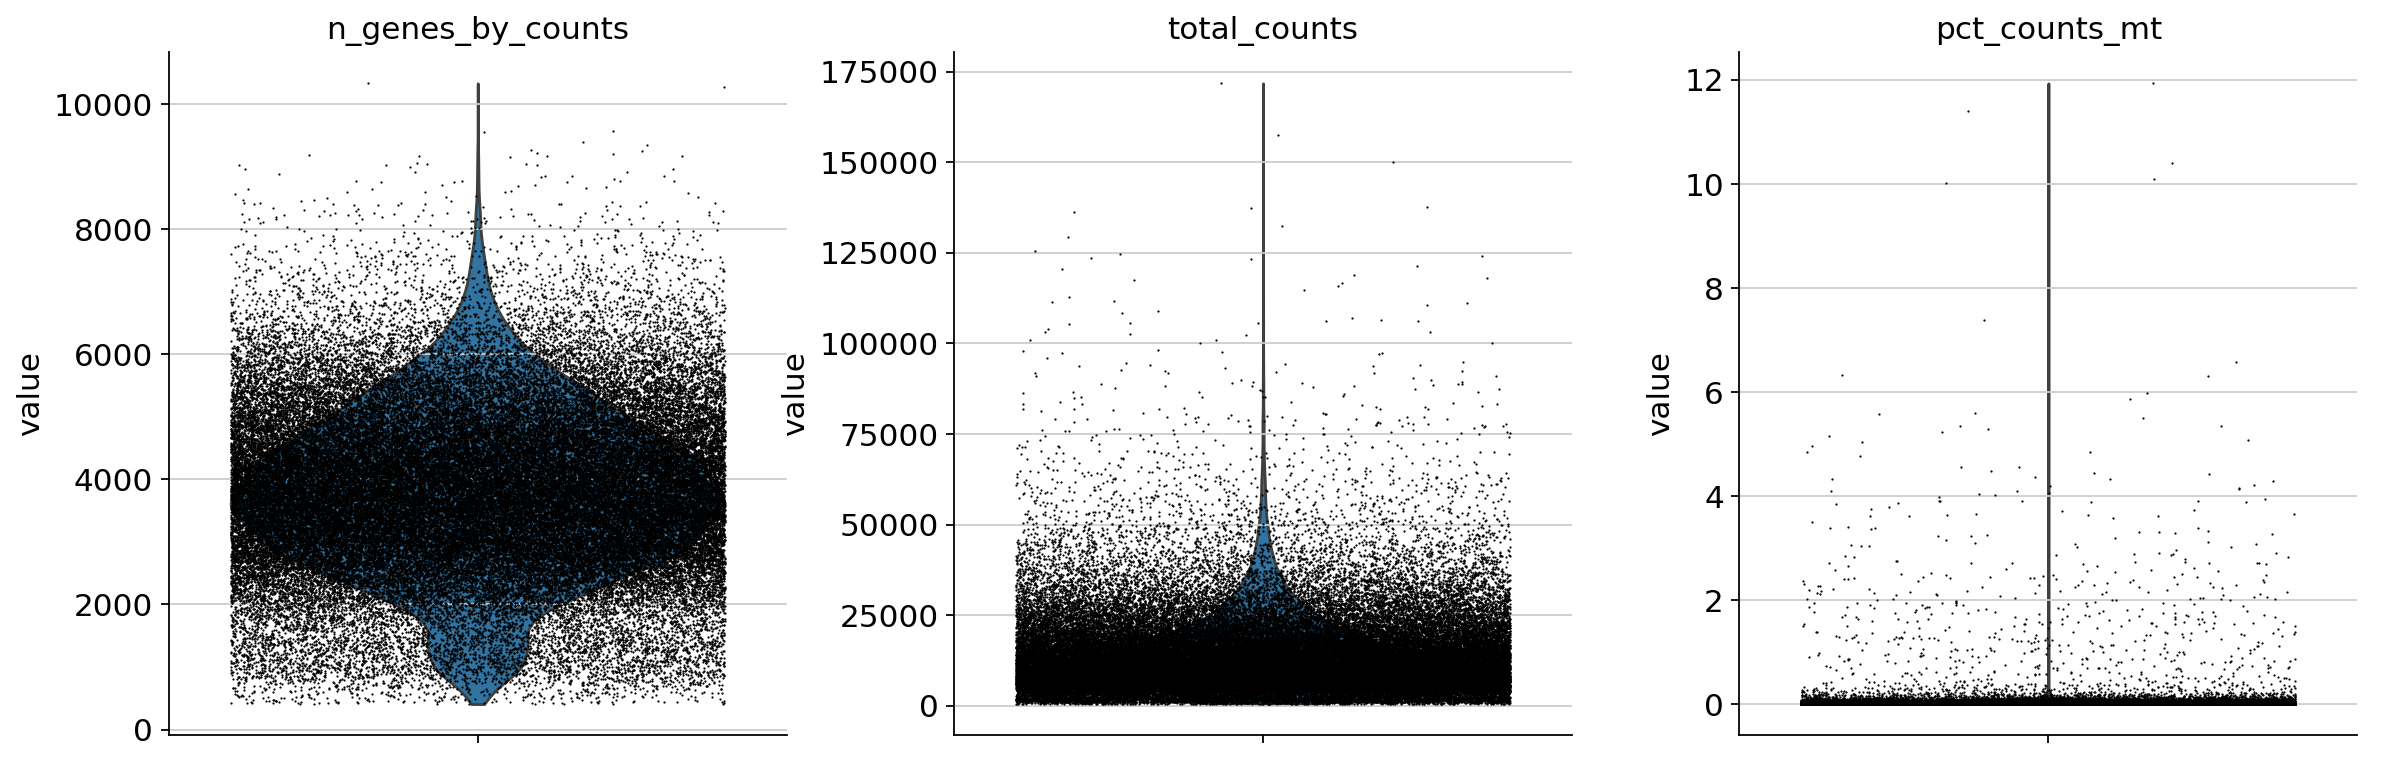

In [ ]:
# annotate the group of mitochondrial genes as 'mt'
# calculate percent ribosomal genes
ribo_genes = adata.var_names.str.startswith(("Rps","Rpl"))
print(sum(ribo_genes))
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
adata.var['mt'] = adata.var_names.isin(mt_genelist['gene'])
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_mt'],jitter=0.4, multi_panel=True,show=False)

#plt.savefig(os.path.join(output_dir,"mt_qc.png"))
#plt.show()

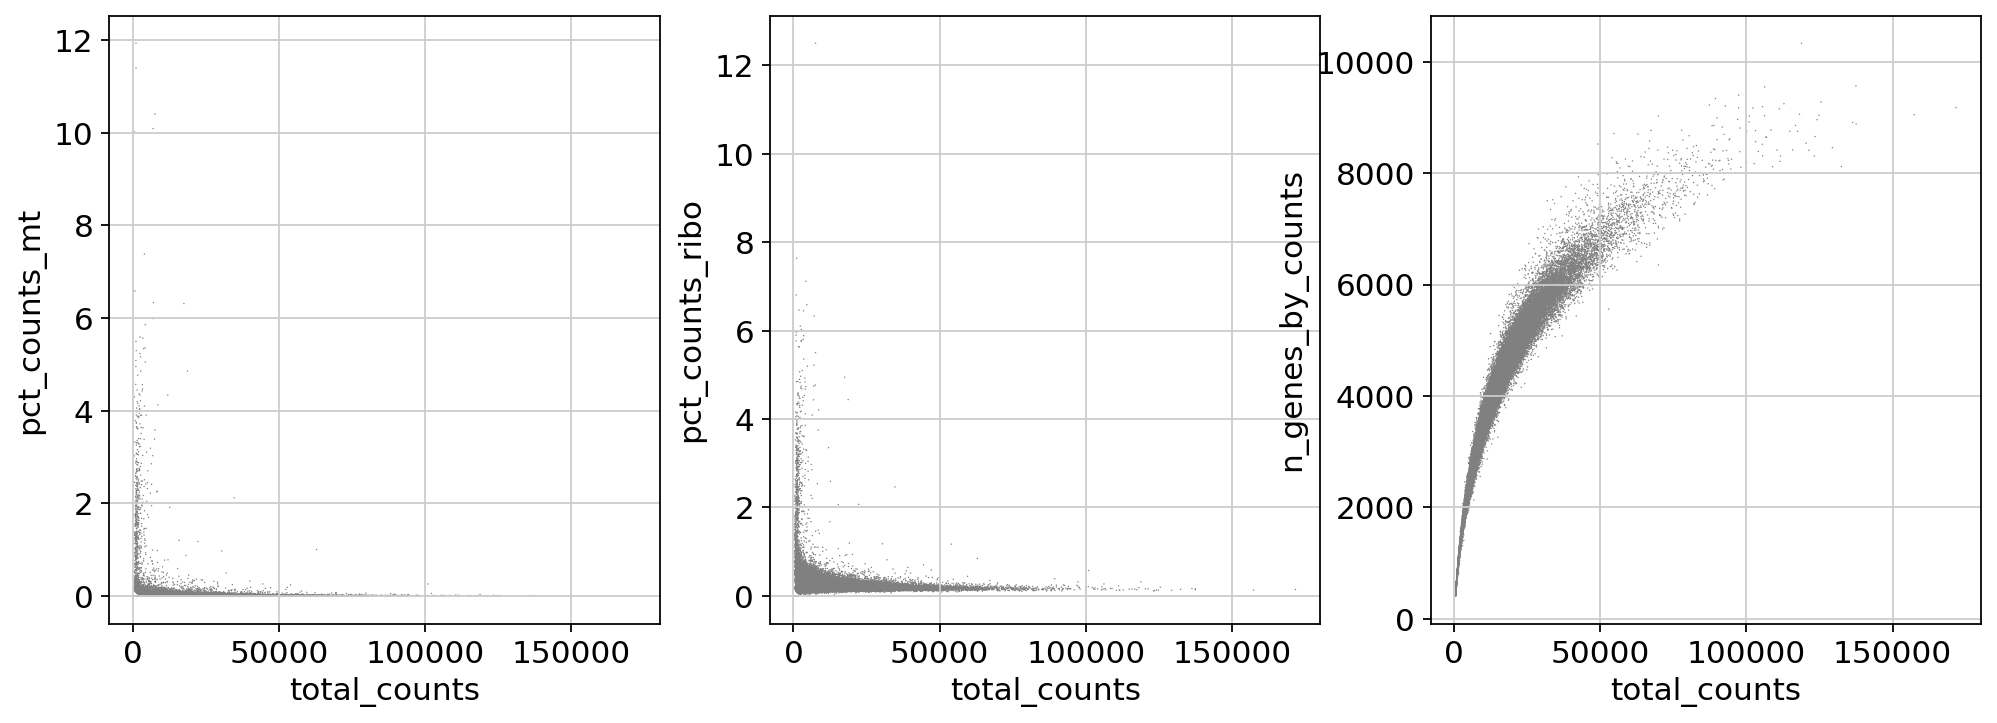

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',show=False,ax = ax1)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo',show=False,ax = ax2)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',show=False, ax=ax3)
plt.savefig(os.path.join(output_fig_dir,"mt_ribo_counts.png"))


filtered out 95 cells that have less than 500 genes expressed
filtered out 21 cells that have more than 9000 genes expressed
filtered out 3056 genes that are detected in less than 3 cells
filtered out 406 cells that have less than 1000 counts
filtered out 29 cells that have more than 100000 counts


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


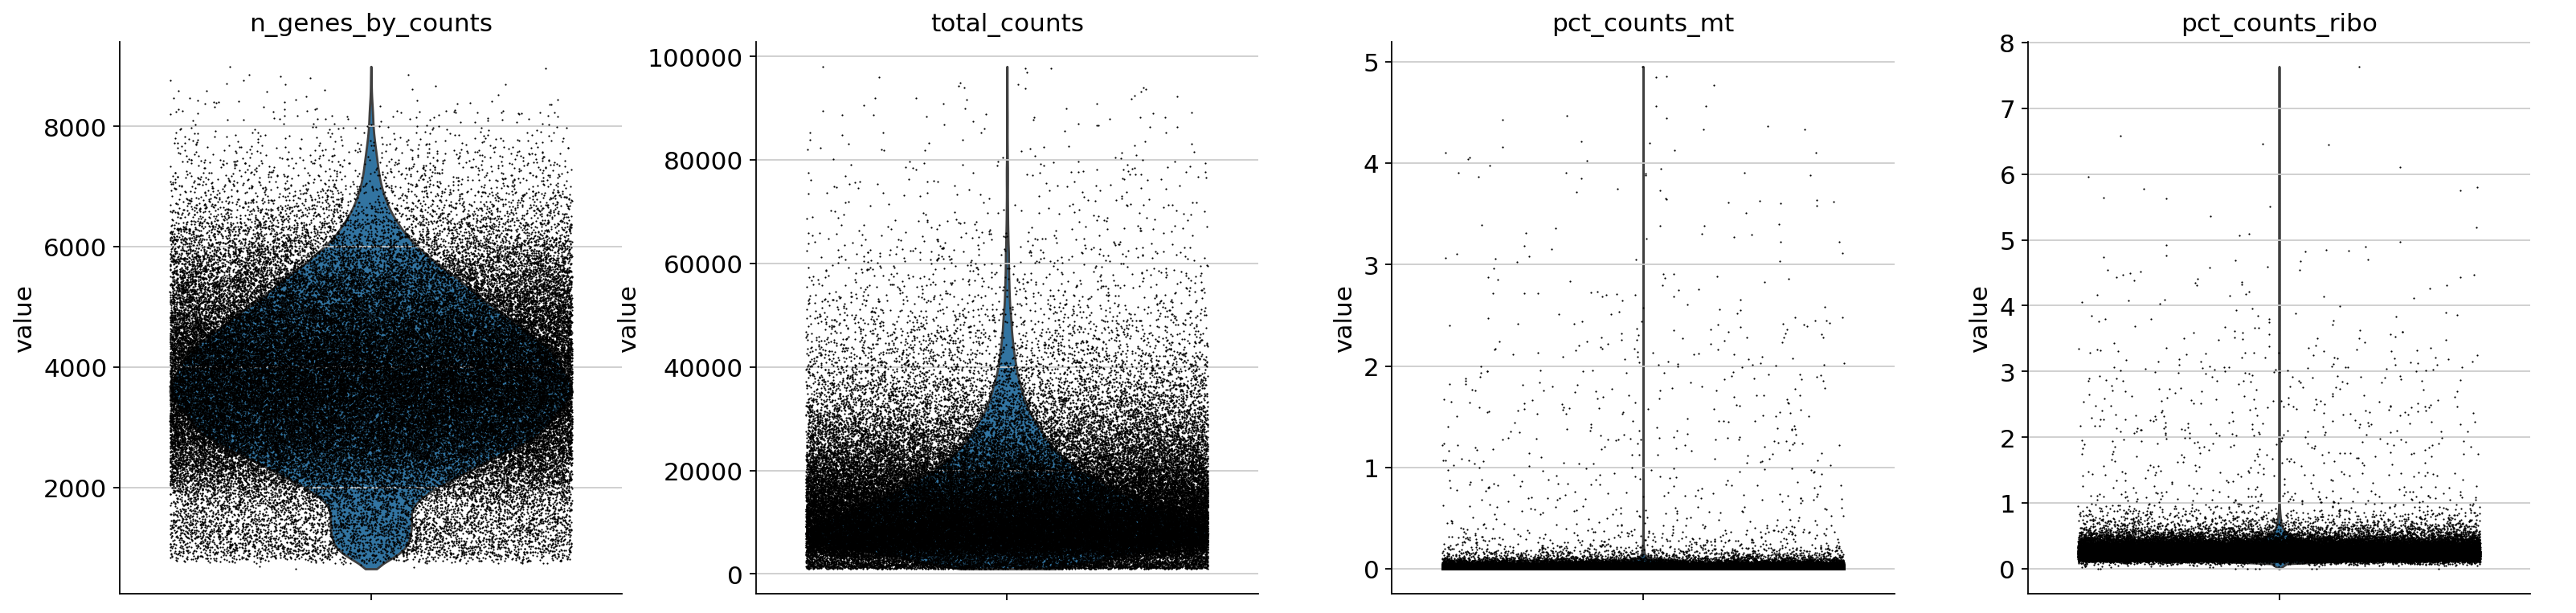

In [ ]:
#filter cells with greater or equal to 5% mt counts
#filter cells with more or equal to 2500 mt genes
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_genes = 9000)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata,min_counts=1000)
sc.pp.filter_cells(adata,max_counts=100000)
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],jitter=0.4, multi_panel=True,show=False)
plt.savefig(os.path.join(output_fig_dir,"after_filtering_mt_ribo_qc.png"))

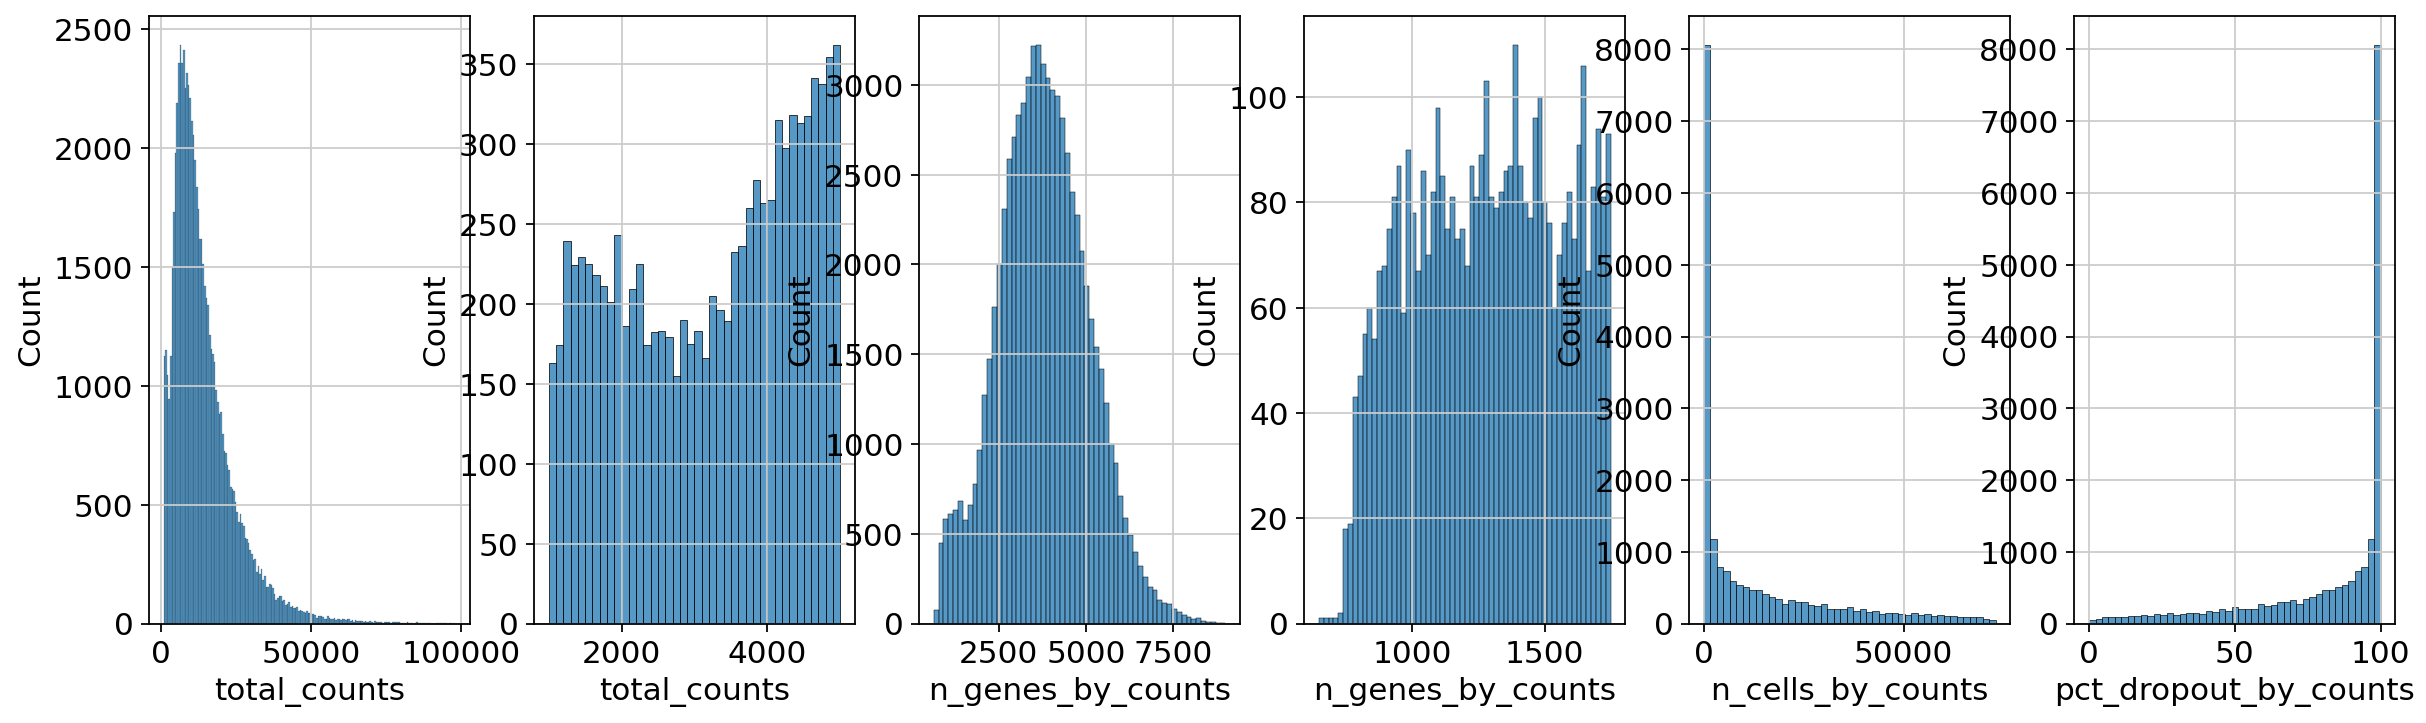

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(18, 5))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 5000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1750], kde=False, bins=60, ax=axs[3])
sns.histplot(adata.var["n_cells_by_counts"], kde=False, ax=axs[4])
sns.histplot(adata.var["pct_dropout_by_counts"], kde=False, ax=axs[5])
plt.savefig(os.path.join(output_fig_dir,"counts_dist.png"))

In [ ]:
#normalization
#normalize to 10000 reads, log transformed,
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:15)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


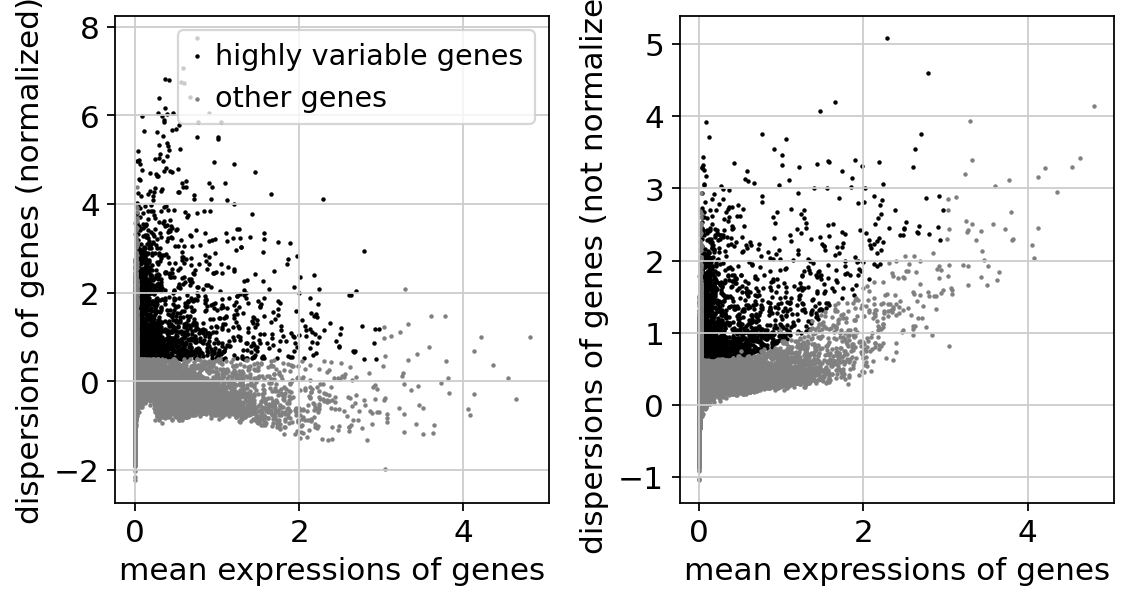

In [ ]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.025, max_mean=3, min_disp=0.5,flavor='seurat',batch_key='sample')
sc.pl.highly_variable_genes(adata,show=False)
plt.savefig(os.path.join(output_fig_dir,"highly_variable_genes.png"))

In [ ]:
adata.raw = adata

In [ ]:
hvg_df = pd.DataFrame()
hvg_df['gene'] = adata.var_names
hvg_df['hvg'] = adata.var.highly_variable.tolist()
hvg_df.to_csv(os.path.join(output_dir,"hvg.txt"),index=False,sep="\t")

normalizing counts per cell
    finished (0:00:01)


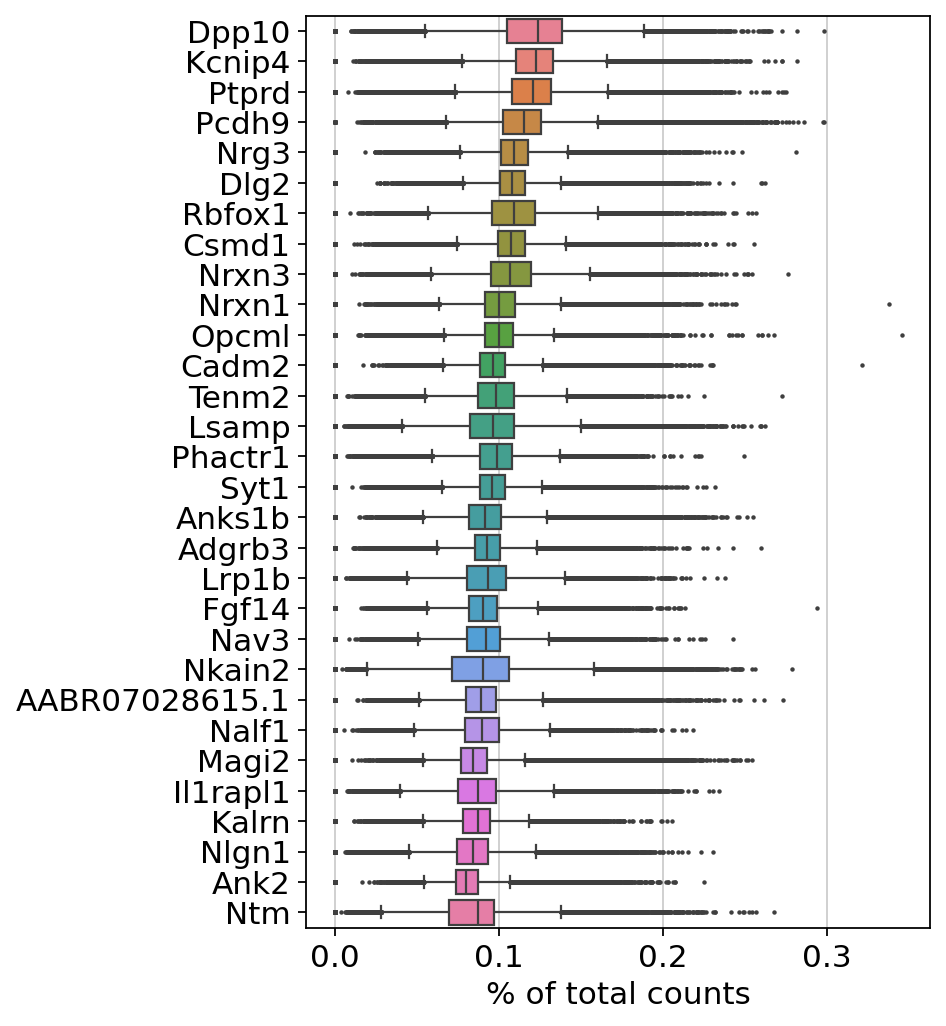

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=30)

In [ ]:
#rempve predicted doublet
adata = adata[adata.obs.predicted_doublet == False,:]

In [ ]:
#The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and auto-detected by PCA and hence, sc.pp.neighbors and subsequent manifold/graph tools. In that case, the step actually do the filtering below is unnecessary, too.

#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt','pct_counts_ribo'])
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)


In [ ]:
hvg = adata.var_names[adata.var.highly_variable]
hvg_ribo = [g for g in hvg if g.startswith('Rps') or g.startswith('Rps')]
#remove mt, ribosomal genes from highly variable genes
adata = adata[:,~adata.var_names.isin(rm_genelist)]
adata.var['highly_variable'][adata.var_names.str.startswith('Pps')] = False
adata.var['highly_variable'][adata.var_names.str.startswith('Rpl')] = False
hvg_df = pd.DataFrame()
hvg_df['gene'] = adata.var_names
hvg_df['hvg'] = adata.var.highly_variable.tolist()
hvg_df.to_csv(os.path.join(output_dir,"hvg.txt"),index=False,sep="\t")

computing PCA
    on highly variable genes
    with n_comps=50


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


    finished (0:00:09)


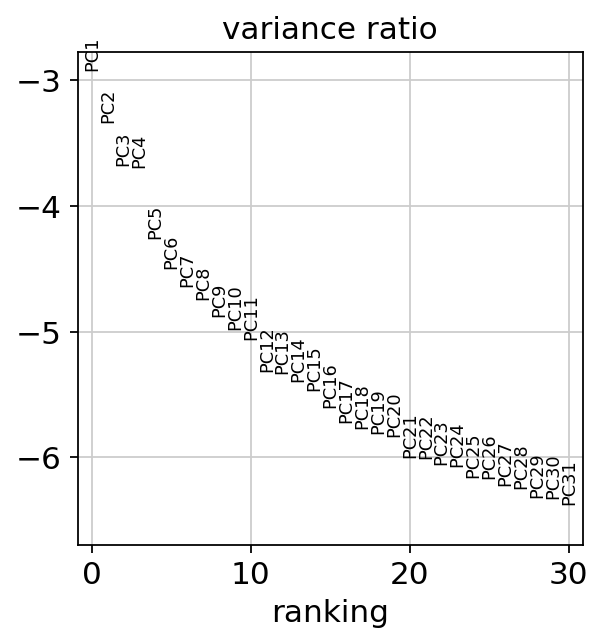

In [ ]:
#Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True,show=False)
plt.savefig(os.path.join(output_dir,"pca_var_ratio.png"))

In [ ]:
#batch correction
sc.external.pp.harmony_integrate(adata, 'sample')
#replcae PCA by the batch corrected data
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.2)

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


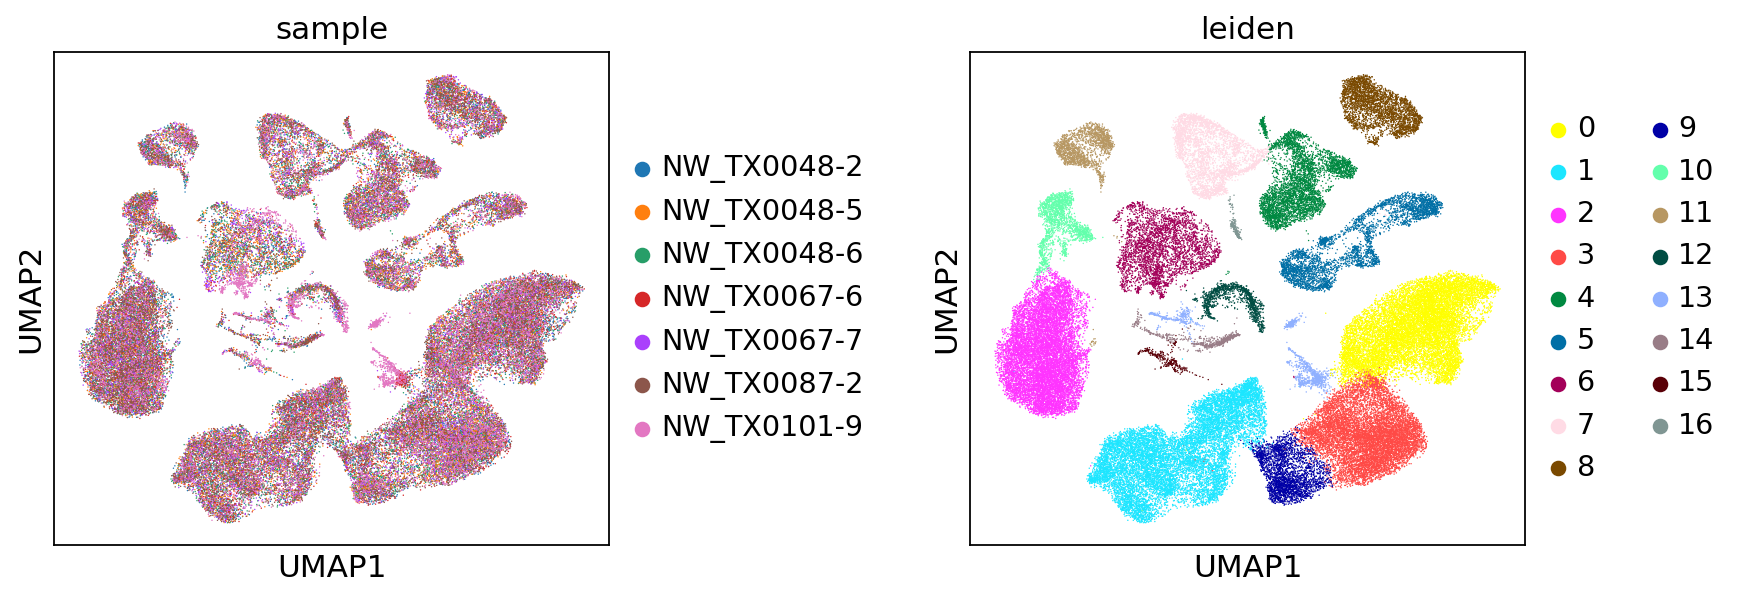

In [ ]:
sc.pl.umap(adata, color=["sample",'leiden'], cmap="tab20",show=False,wspace = 0.5)
plt.savefig(os.path.join(output_fig_dir,"Harmony_umap_by_sample.png"))

In [ ]:
#calculate paga & plot
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False,show =False,use_raw=True)  # remove `plot=False` if you want to see the coarse-grained graph
#plt.savefig(os.path.join(output_dir,"paga_leiden_cluster.png"))
#show which genes are active in which clusters for the three overall clusters (umap)
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=["sample",'leiden'], cmap="tab20",show=False,wspace = 0.5)
plt.savefig(os.path.join(output_fig_dir,"Harmony_umap_by_sample.png"))

In [ ]:

GABAergic = ["Gad1"]
Glutamatergic = ["Sv2b","Arpp21"]
Non_Neuronal = ["Mbp","Qki"]

marker_genes = GABAergic + Glutamatergic + Non_Neuronal

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


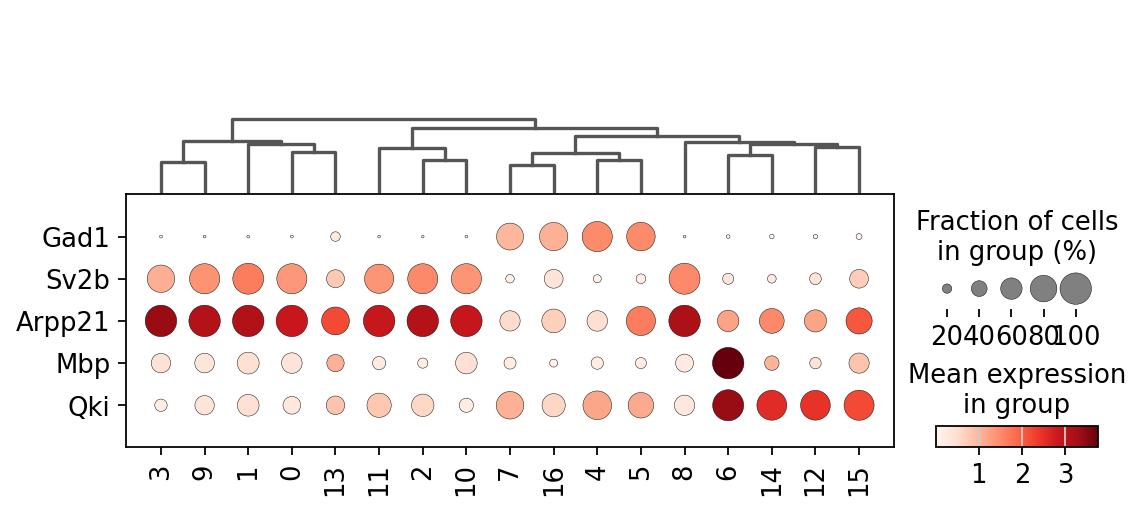

In [ ]:
sc.pl.dotplot(adata, var_names=marker_genes, groupby="leiden", dendrogram=True, swap_axes=True)

In [ ]:
inh_cls = ["4","5","7","16"]
exc_cls = ["0","1","2","3","9","13","11","10","8"]
non_cls = ["6","12","14","15"]

In [ ]:
inh_smps = adata.obs_names[adata.obs.leiden.isin(inh_cls)]
exc_smps = adata.obs_names[adata.obs.leiden.isin(exc_cls)]
glial_smps = adata.obs_names[adata.obs.leiden.isin(non_cls)]
print(len(inh_smps))
print(len(exc_smps))
print(len(glial_smps))

In [ ]:
adata.obs['class'] = np.empty([adata.n_obs], dtype=str)
for i in inh_smps:
  adata.obs.loc[i, 'class'] = 'GABAergic'
for i in exc_smps:
  adata.obs.loc[i, 'class'] = 'Glutamatergic'
for i in glial_smps:
  adata.obs.loc[i, 'class'] = 'Non_Neural'

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


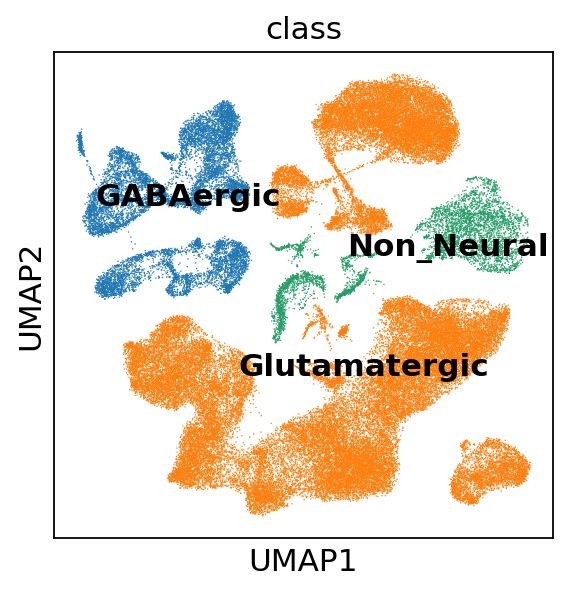

In [ ]:
sc.pl.umap(adata, color=['class'], legend_loc='on data', show=False)
plt.savefig(os.path.join(output_fig_dir,"rat_class_umap.png"))

In [ ]:
adata.write_h5ad(os.path.join(output_dir,"rat_all_norm_class.h5ad"),compression='gzip')

In [ ]:
exc_adata = adata[adata.obs_names.isin(exc_smps),:]
inh_adata = adata[adata.obs_names.isin(inh_smps),:]
glial_adata = adata[adata.obs_names.isin(glial_smps),:]

#print(exc_adata)
#make a new dataset for each cell type
exc_adata.write_h5ad(os.path.join(output_dir,"exc_class.h5ad"),compression='gzip')
inh_adata.write_h5ad(os.path.join(output_dir,"inh_class.h5ad"),compression='gzip')
glial_adata.write_h5ad(os.path.join(output_dir,"glial_class.h5ad"),compression='gzip')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:04:01)


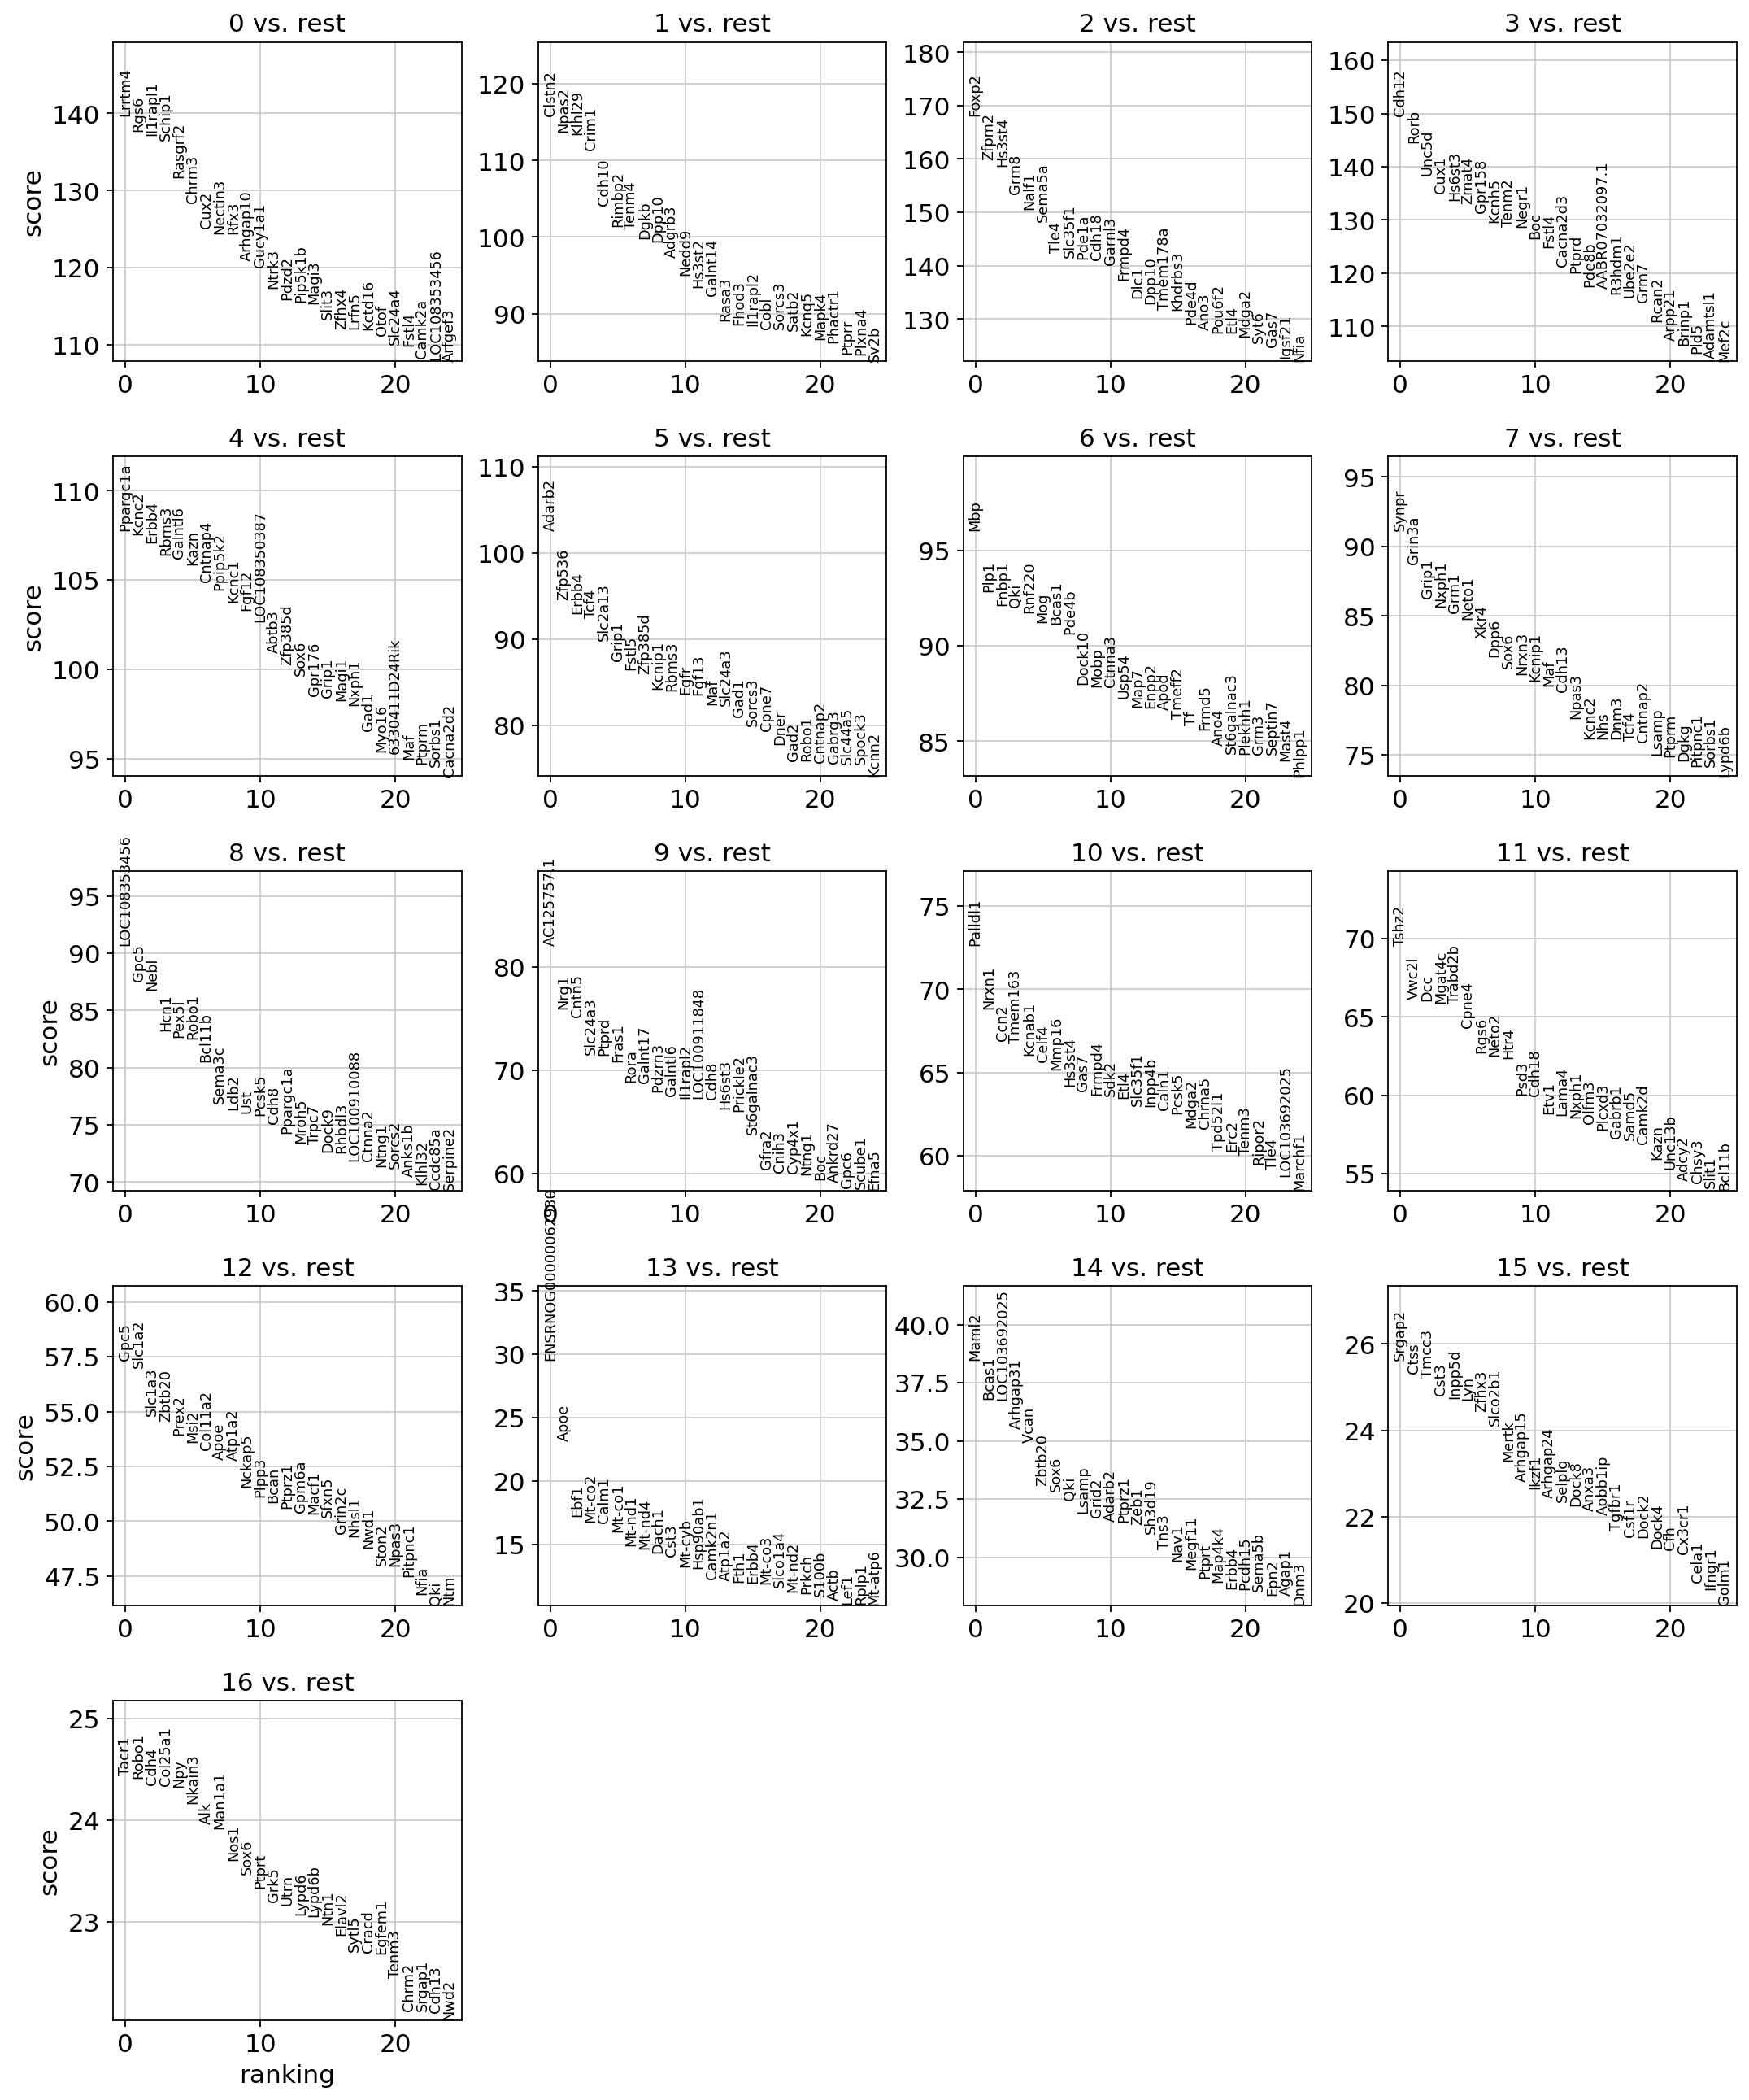

In [ ]:
#Get the most variable genes that define each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,show=False)
plt.savefig(os.path.join(output_fig_dir,"rank_genes_groups.png"))

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


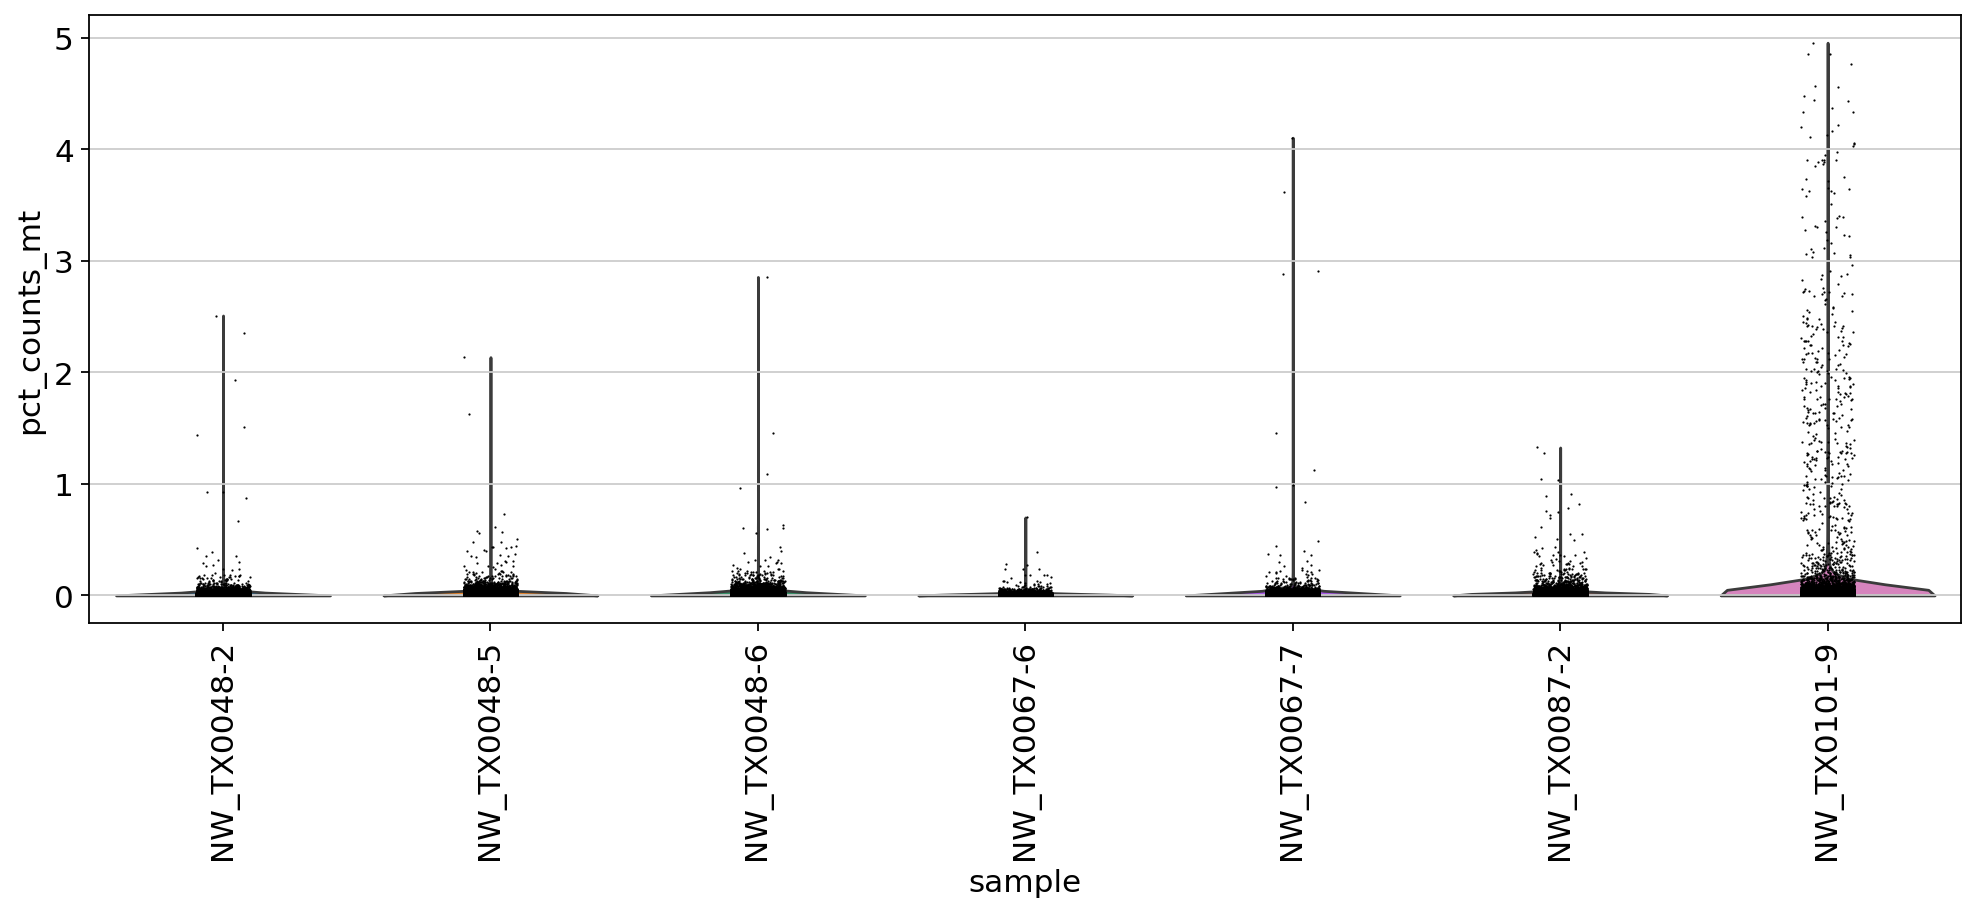

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
plot = sc.pl.violin(adata, keys="pct_counts_mt", groupby="sample", ax=axs, show=False)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(output_fig_dir,"hvg_pct_counts_mt.png"),bbox_inches="tight")

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


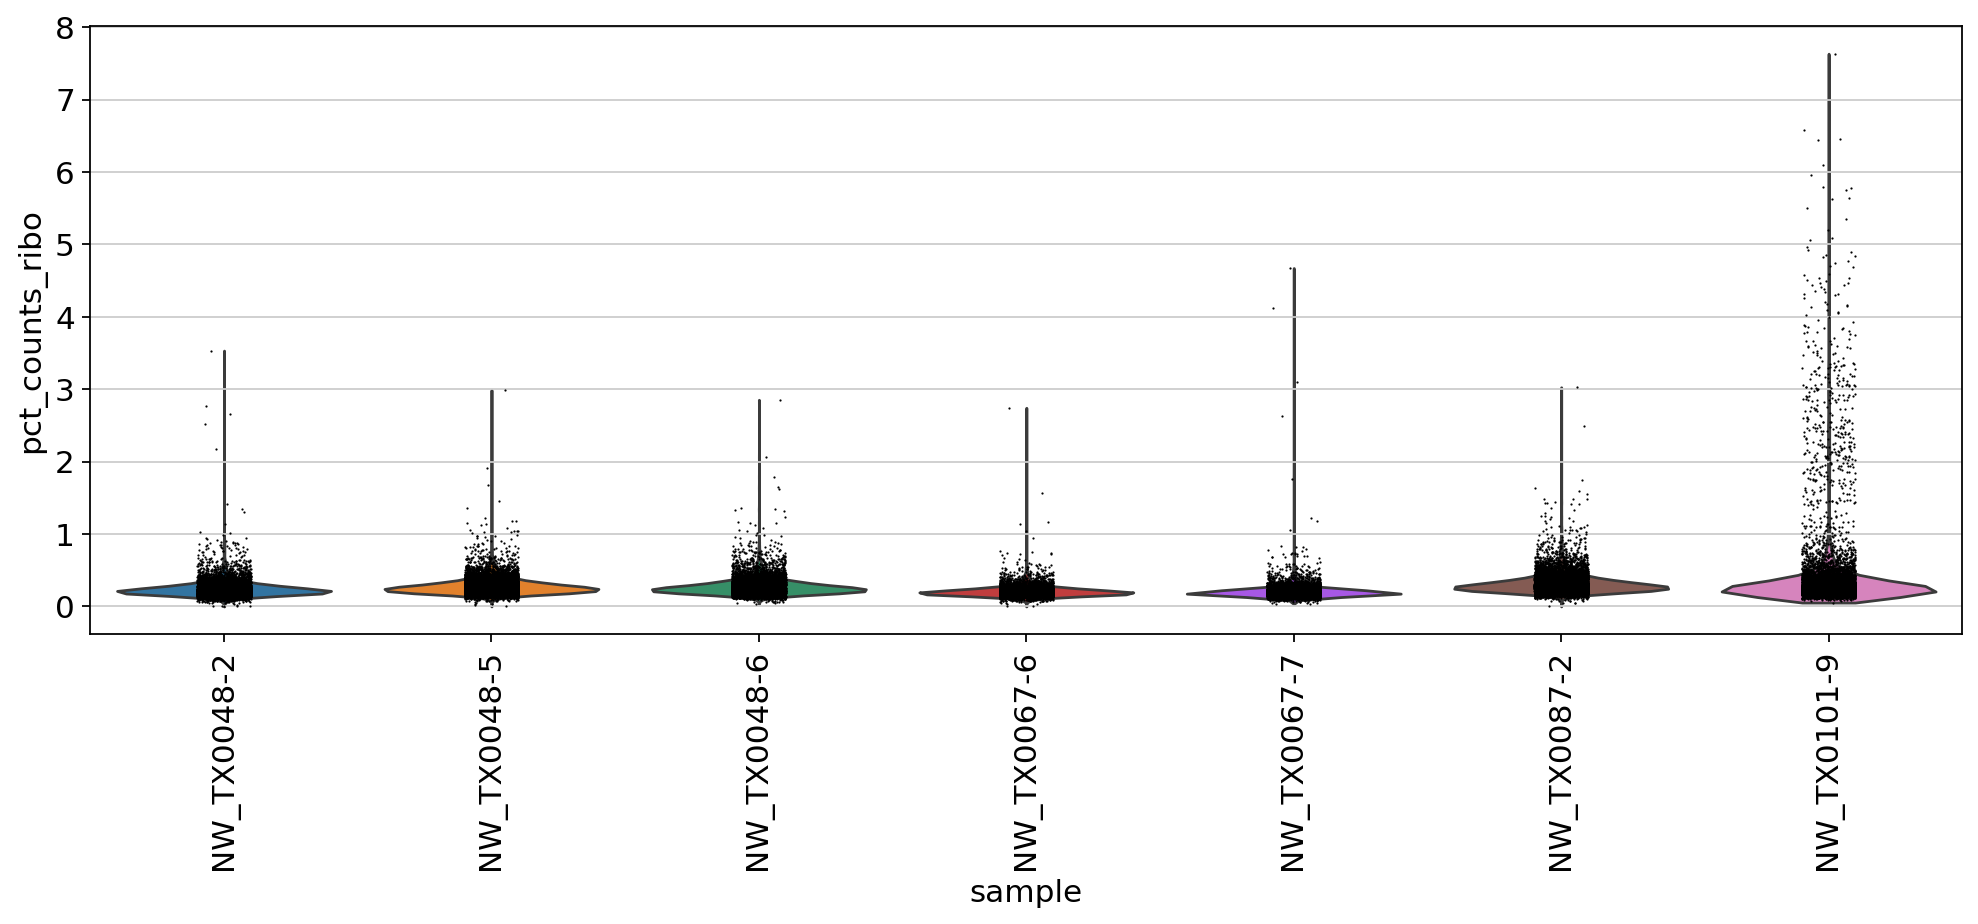

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
plot = sc.pl.violin(adata, keys="pct_counts_ribo", groupby="sample", ax=axs, show=False)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(output_fig_dir,"hvg_pct_counts_ribo.png"),bbox_inches="tight")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


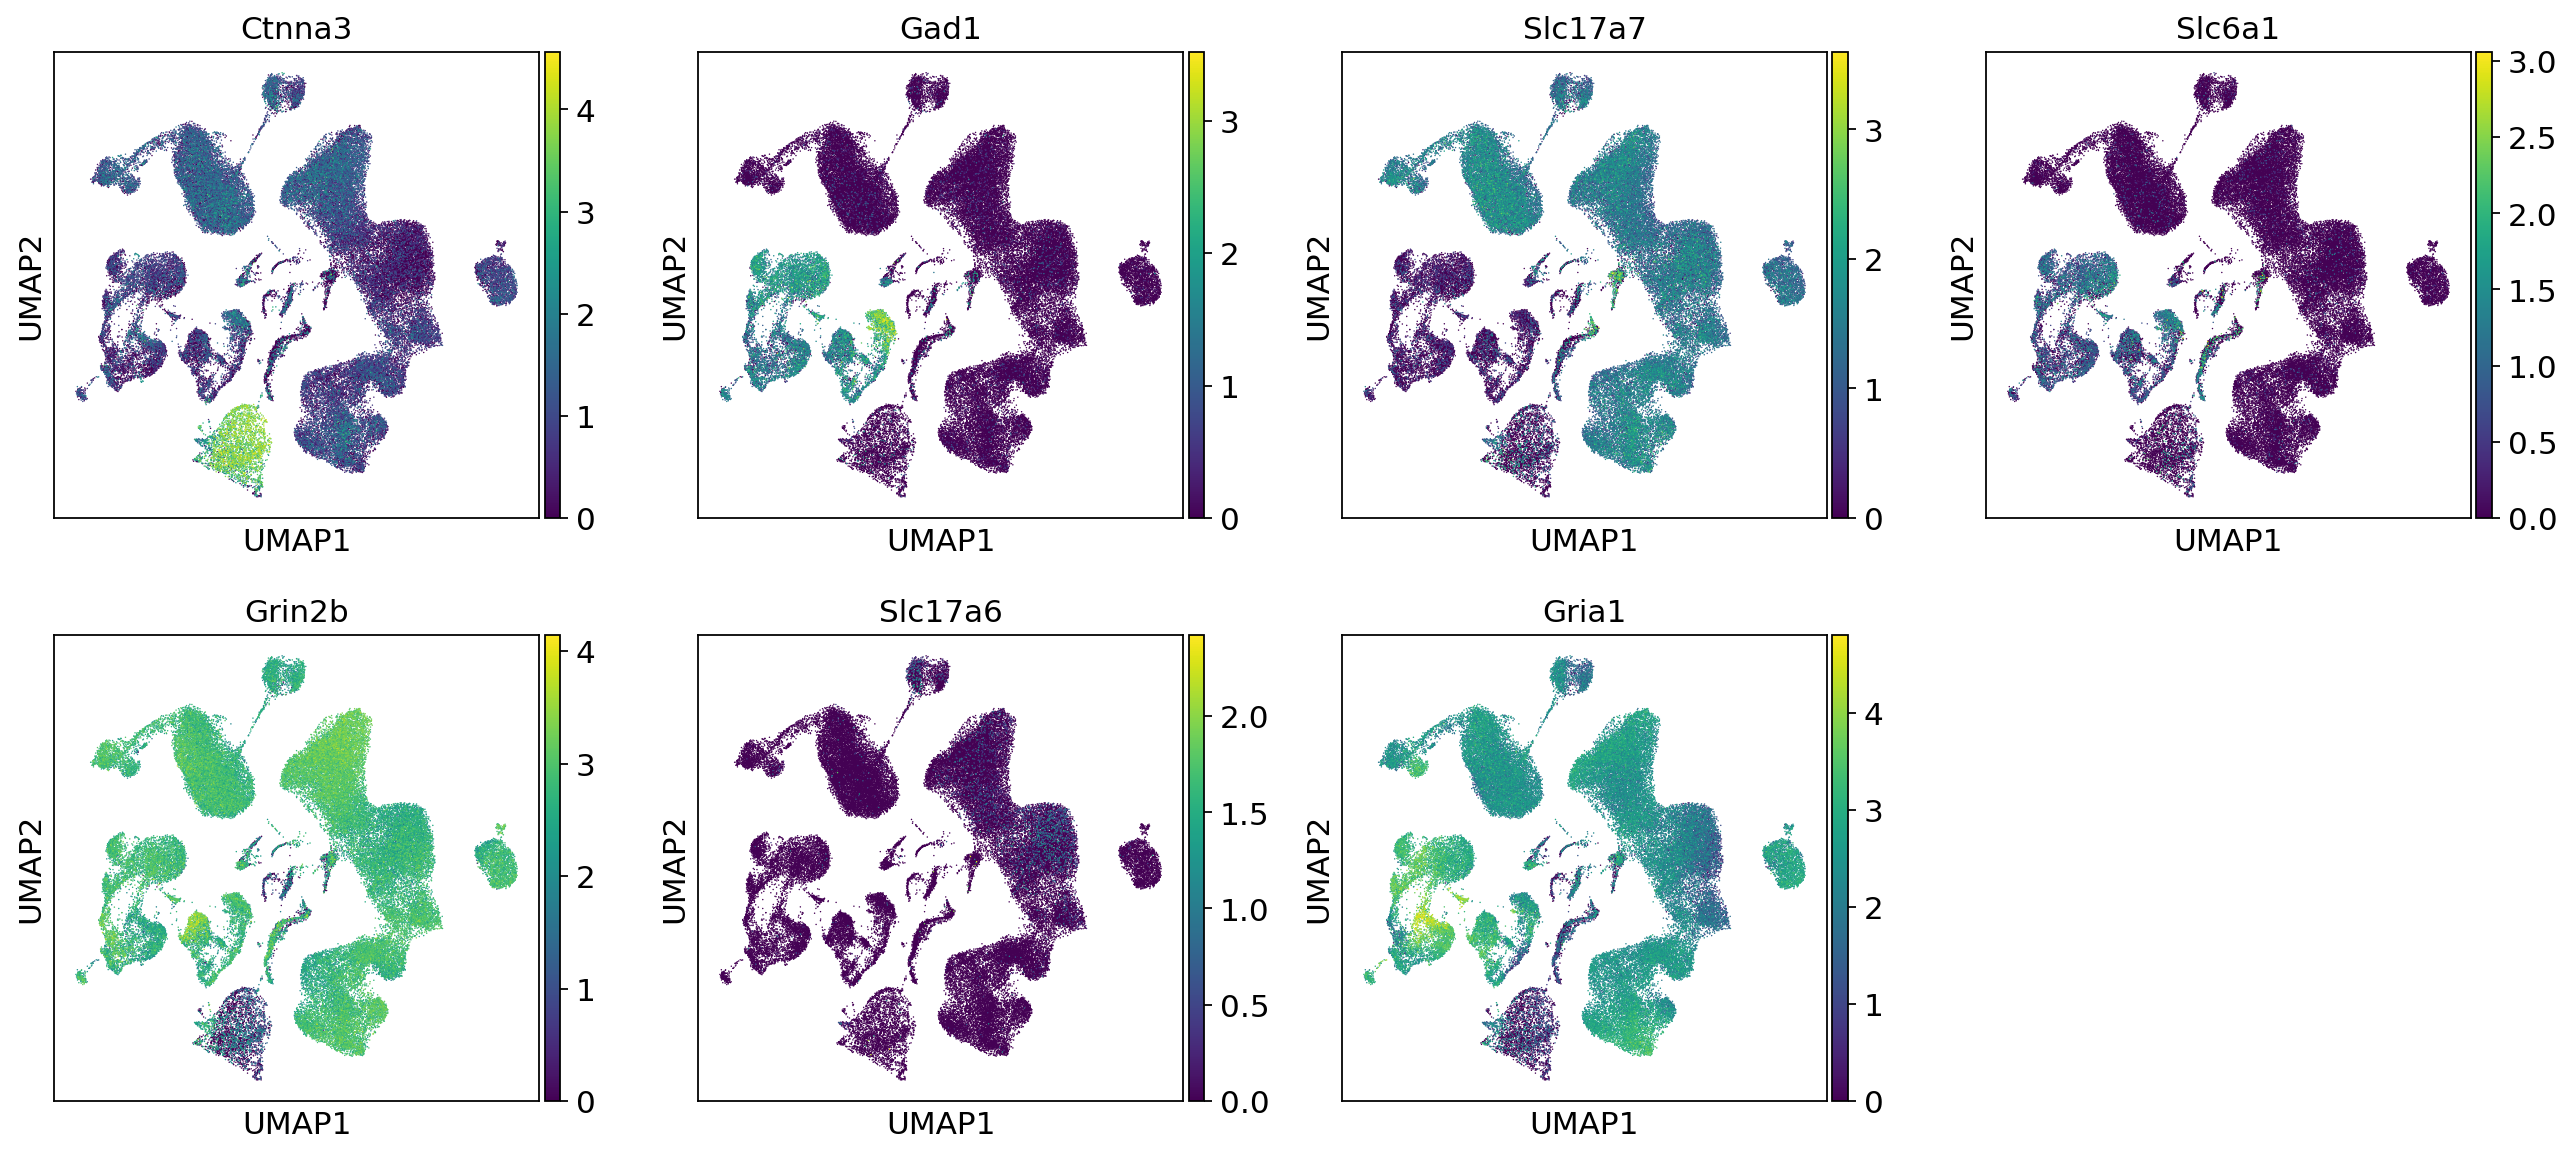

In [ ]:

sc.pl.umap(adata, color=['Ctnna3', 'Gad1', 'Slc17a7','Slc6a1', 'Grin2b', 'Slc17a6', 'Gria1'],show=False)
plt.savefig(os.path.join(output_dir,"rat_umap_by_cluster_on_marker_genes.png"))

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'Srgap2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Syndig1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Arhgap10'}, xlabel='UMAP1', ylabel='UMAP2'>]

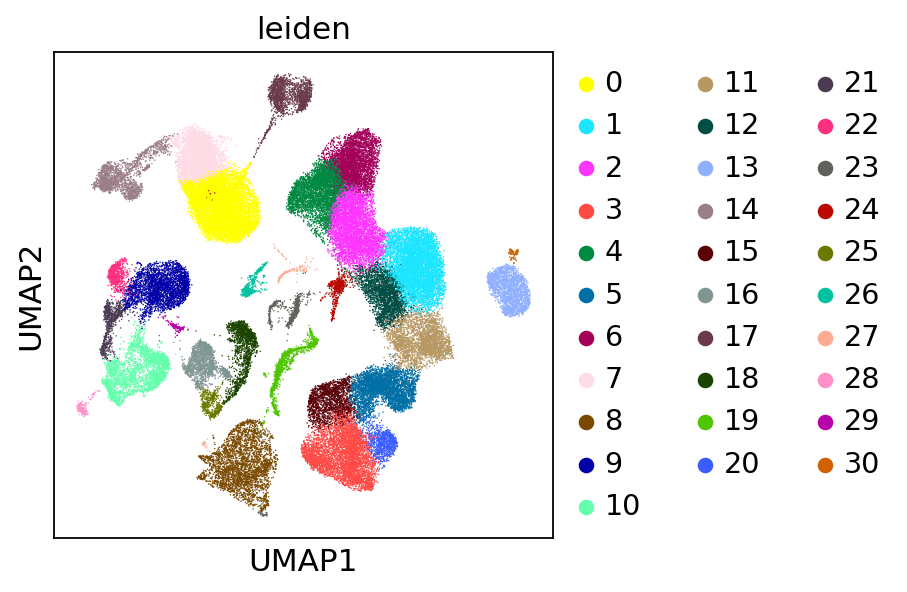

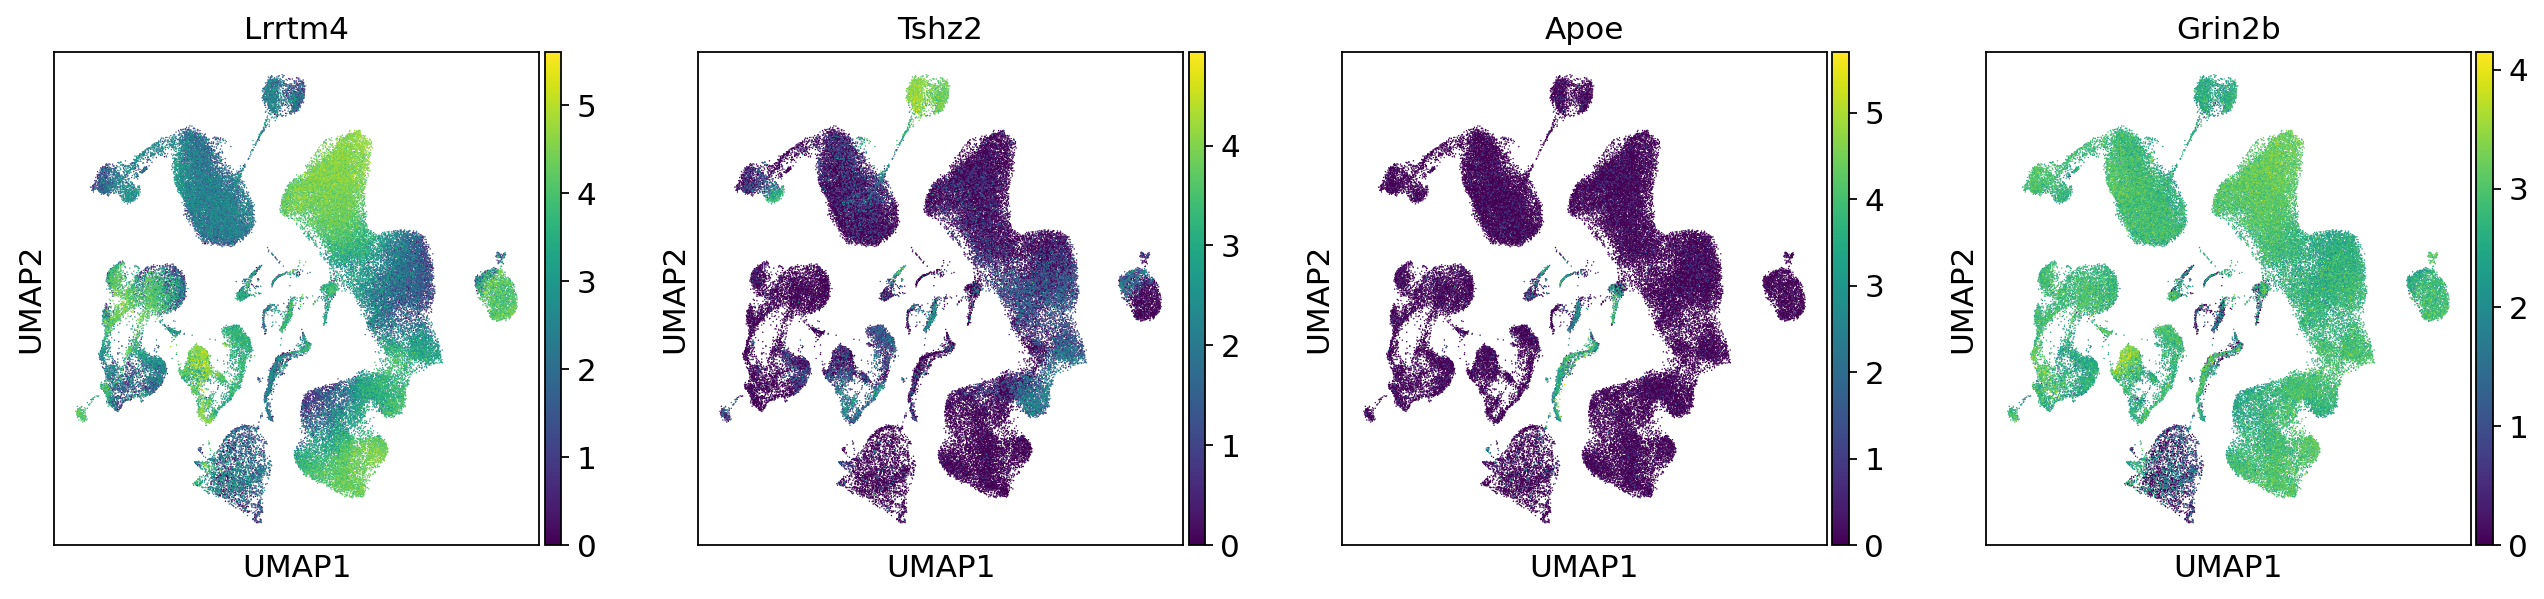

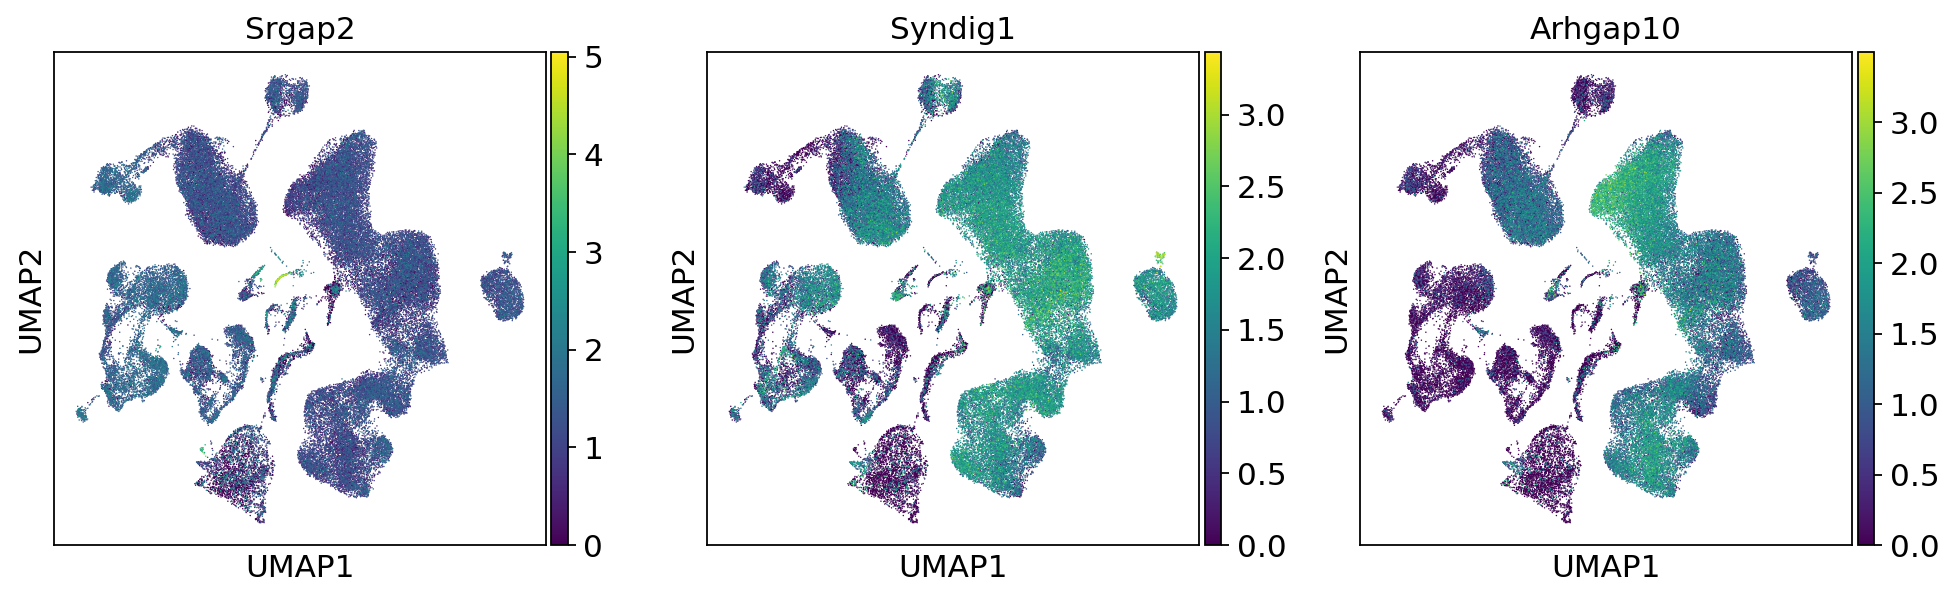

In [ ]:
#sc.pl.umap(adata, color=['Ctnna3', 'Gad1', 'Slc17a7','Slc6a1', 'Grin2b', 'Slc17a6', 'Gria1','Lrrtm4'],show=False)
sc.pl.umap(adata, color=['leiden'],show=False)
sc.pl.umap(adata, color=['Lrrtm4','Tshz2','Apoe','Grin2b'],show=False)
sc.pl.umap(adata, color=['Srgap2','Syndig1','Arhgap10'],show=False)
#plt.savefig(os.path.join(output_dir,"rat_umap_by_cluster_on_marker_genes.png"))

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


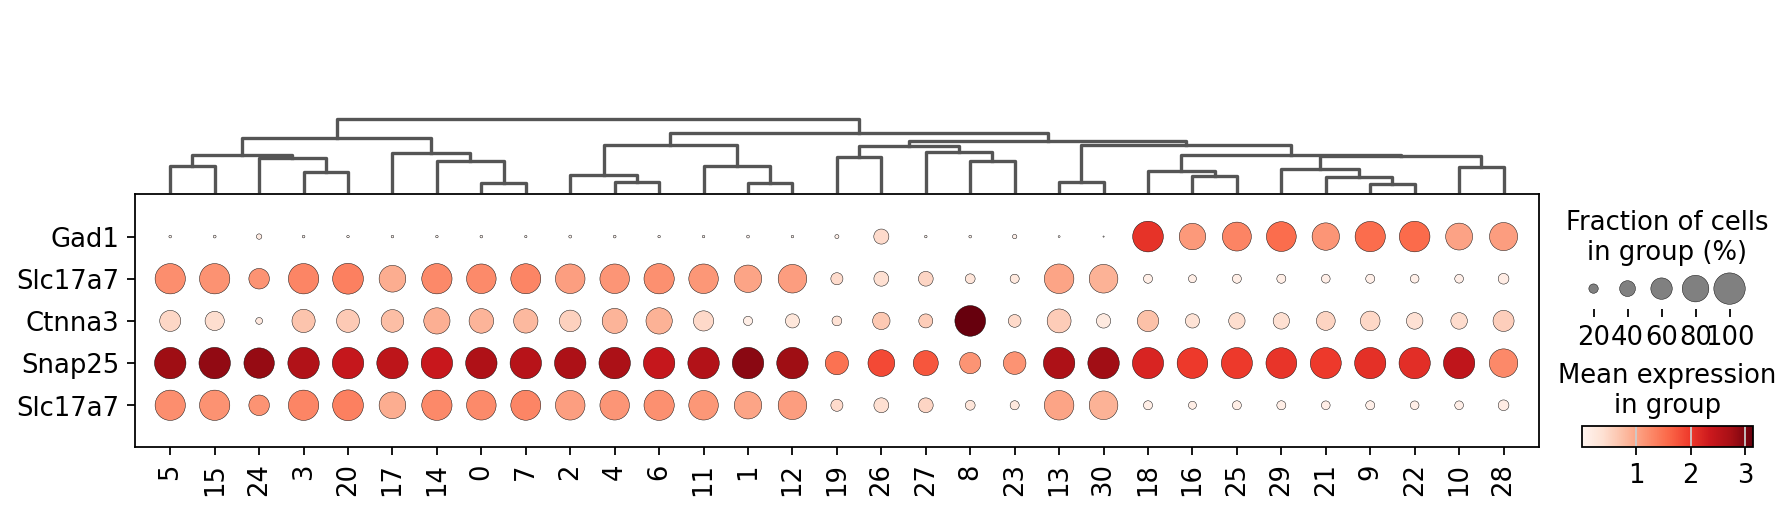

In [ ]:
sc.pl.dotplot(adata, var_names=["Gad1","Slc6a1","Ctnna3","Snap25","Slc17a7"], groupby="leiden", dendrogram=True, swap_axes=True)